![Spark](http://spark.apache.org/docs/latest/img/spark-logo-hd.png)

<img src="http://hortonworks.com/wp-content/themes/hortonworks/images/svg/ui_logo.svg" width="240"/>

## Utilisation de Spark sur le cluster

Ce notebook est un exemple d'application d'une random forest sur le jeu de données nc13.

### Utilisation Jupyter

In [ ]:
1+2

Ceci est de la doc

### Configuration de Python

In [ ]:
# à utiliser pour stopper le contexte Spark
sc.stop()

Configuration du PYTHON_PATH :

In [1]:
import os
import sys
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.9-src.zip'))

Configuration du client Spark, nous utilisons le mode yarn-client :
![Cluster Overview](http://spark.apache.org/docs/latest/img/cluster-overview.png)

In [2]:
import os
import pyspark

conf = pyspark.SparkConf()
conf.setMaster('yarn-client')

sc = pyspark.SparkContext(conf=conf)

In [3]:
sc.master

u'yarn-client'

### Spark sur YARN

![HDP platform](HDP_architecture.png)

### Chargement des données

Les données ont été chargées sur HDFS dans le répertoire /user/geraud/shazam. Ici, nous allons utiliser les fichiers convertis au format Parquet (dans le répertoire /user/geraud/shazam/parquet).

In [4]:
from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as F

On initialise un SQLContext, qui va nous permettre de charger les données sous forme de Data.Frame.
Un DataFrame est une représentation tabulaire des données (à la Excel): https://spark.apache.org/docs/1.6.2/sql-programming-guide.html

In [5]:
sqlContext = SQLContext(sc)

In [6]:
mfcc = sqlContext.read.parquet('/user/geraud/shazam/parquet/nc13-train.parquet')
mfcc.show(5)

+-------+--------------+-------------+---------------+-------------+-------------+--------------+-------------+-------------+--------------+---------------+---------------+-------------+--------------+-------+--------+
|idSound|       bands_1|      bands_2|        bands_3|      bands_4|      bands_5|       bands_6|      bands_7|      bands_8|       bands_9|       bands_10|       bands_11|     bands_12|      bands_13|mfccSeq|   class|
+-------+--------------+-------------+---------------+-------------+-------------+--------------+-------------+-------------+--------------+---------------+---------------+-------------+--------------+-------+--------+
|    274|-901.902099609| 163.83505249| -11.8038024902|19.7777748108|19.9015960693|-4.03476715088|18.4968910217|12.1045322418|-1.85980224609|-0.522010803223|  1.58743667603|2.35488128662|-9.13202285767|      1|dog_bark|
|    274|-884.952514648|154.302032471| -24.4797782898|35.2823219299|8.37690734863|-21.6676330566|14.3066902161| 2.4754486084

In [7]:
mfcc.describe().toPandas()

,summary,idSound,bands_1,bands_2,bands_3,bands_4,bands_5,bands_6,bands_7,bands_8,bands_9,bands_10,bands_11,bands_12,bands_13,mfccSeq
0,count,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063,3388063
1,mean,625.994764855317,-797.7422305973885,130.52924950007187,-8.68417880599472,9.93409146380984,-2.213174698431618,2.79919745596125,0.2200321438486301,1.4286656845608057,-0.5015752394078972,0.7480491144689811,-0.9110609097398981,0.25667787701983746,-0.5979051189166785,4830.286625130642
2,stddev,378.89575690717896,133.466217254147,53.08886778297778,40.18542865854186,26.5668552706278,20.88320375826346,18.634787517218594,16.730487031561562,14.252464640045202,13.331844923590173,12.479857078817725,11.4122629628578,11.01843263226996,10.718384230849887,4959.522103508154
3,min,1,-1138.42004395,-187.382949829,-245.321746826,-159.592193604,-156.033447266,-117.476898193,-116.255081177,-93.6179351807,-94.7189712524,-106.444740295,-77.8643798828,-86.0950698853,-102.984832764,1
4,max,1301,-303.506225586,327.894744873,159.329299927,163.017944336,125.203155518,111.745773315,102.688072205,105.055770874,91.7920837402,91.9693603516,91.0449066162,91.9013214111,86.9623718262,26210


### Opérations sur des DataFrames

In [ ]:
mfcc.filter(mfcc['class'] == 'dog_bark').select('idSound', 'bands_1', 'class').show(5)

In [ ]:
mfcc.groupBy('idSound').mean('bands_1').toPandas()

En mode SQL:

In [ ]:
sqlContext.registerDataFrameAsTable(mfcc, 'mfcc')
sqlContext.tableNames()

In [ ]:
sqlContext.sql("SELECT idSound, AVG(bands_1), class FROM mfcc GROUP BY idSound, class").toPandas()

#### Principes

Spark permet d'effectuer 2 types d'opérations sur les DataFrames: les *transformations*  et les *actions*.

* Exemples de transformations : map, flatMap, filter...
* Exemples d'actions : collect, show...

Les transformations ne sont exécutées qu'au moment de l'appel à une action.


In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# number of bins
n = 30

In [10]:
histo_1 = mfcc.select("bands_1").rdd.flatMap(lambda x: x).histogram(n)

In [11]:
width = histo_1[0][1] - histo_1[0][0]

<Container object of 30 artists>

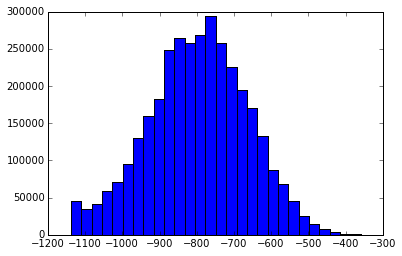

In [12]:
plt.bar(histo_1[0][:n], histo_1[1], width)

In [13]:
featuresNames = [ column for column in mfcc.columns if 'bands_' in column ]
#featuresNames = [ 'bands_1', 'bands_2']
histograms = dict()
for feature in featuresNames:
    print("Computing histogram for %s" % feature)
    histograms[feature] = mfcc.select(feature).rdd.flatMap(lambda x: x).histogram(n)

Computing histogram for bands_1
Computing histogram for bands_2
Computing histogram for bands_3
Computing histogram for bands_4
Computing histogram for bands_5
Computing histogram for bands_6
Computing histogram for bands_7
Computing histogram for bands_8
Computing histogram for bands_9
Computing histogram for bands_10
Computing histogram for bands_11
Computing histogram for bands_12
Computing histogram for bands_13


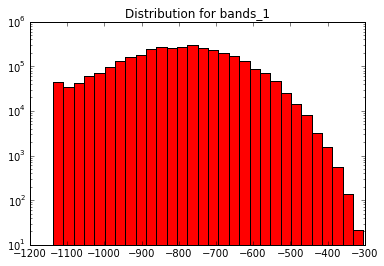

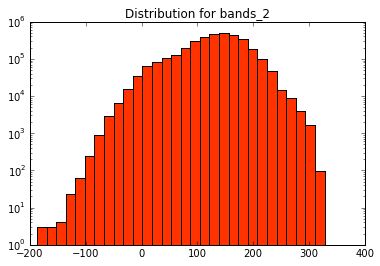

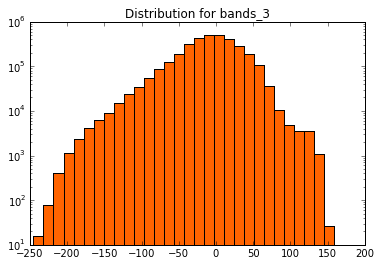

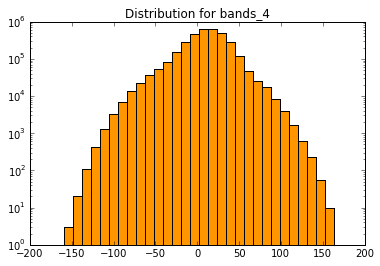

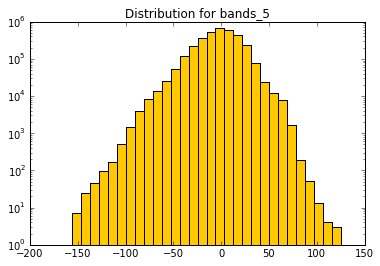

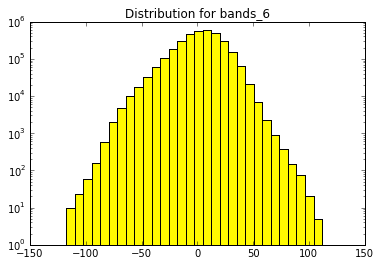

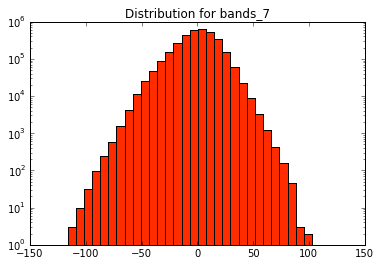

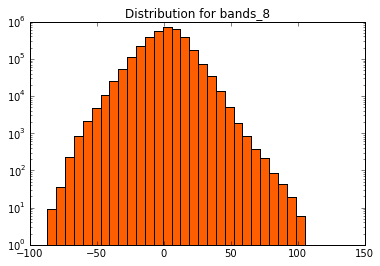

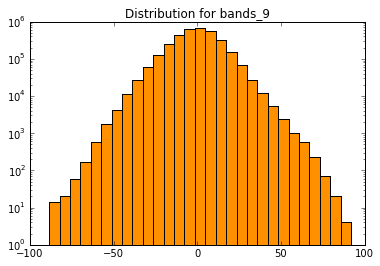

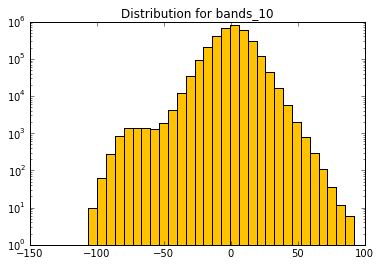

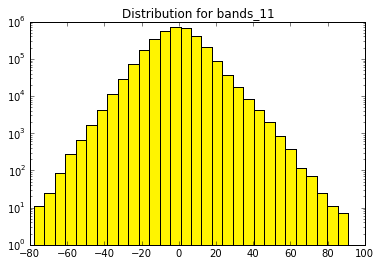

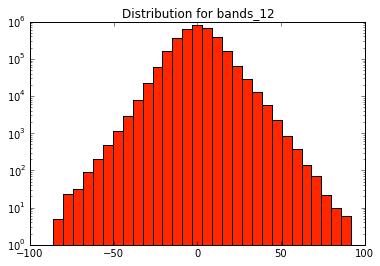

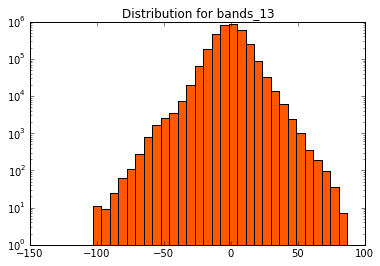

In [14]:
color = 0
for feature in featuresNames:
    histo = histograms[feature]
    width = histo[0][1] - histo[0][0]
    plt.bar(histo[0][:n], histo[1], width, log = True, color = plt.cm.autumn(color))
    color = (color + 50) % 256
    plt.title('Distribution for %s' % feature)
    plt.show()

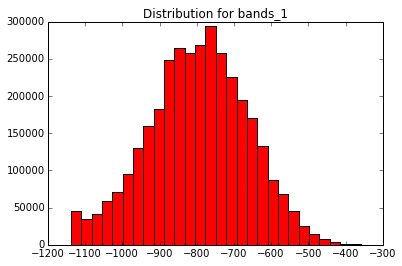

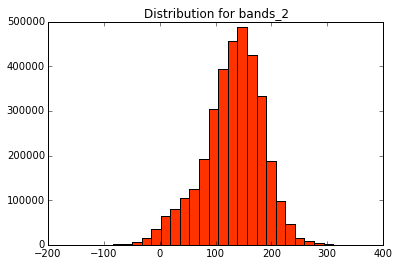

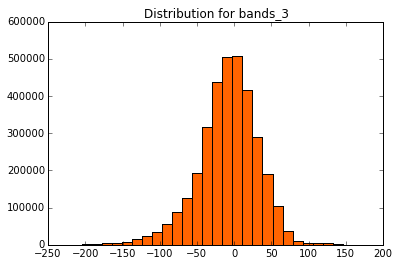

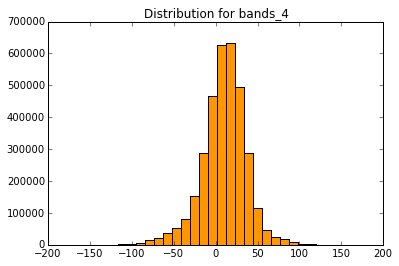

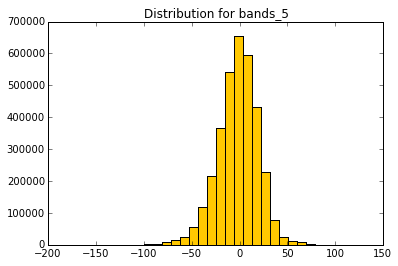

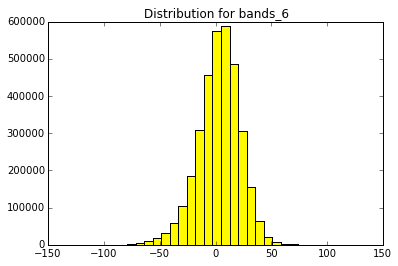

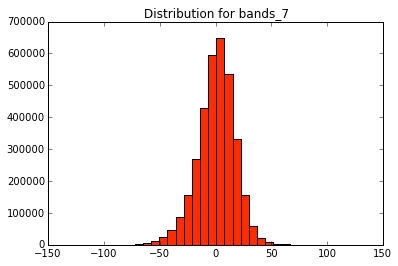

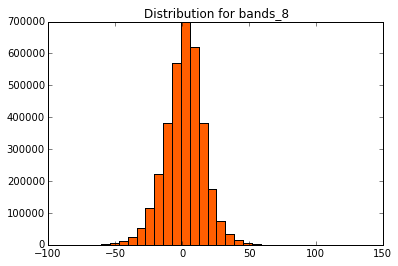

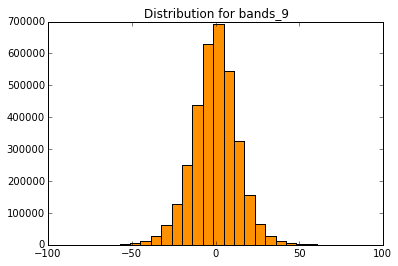

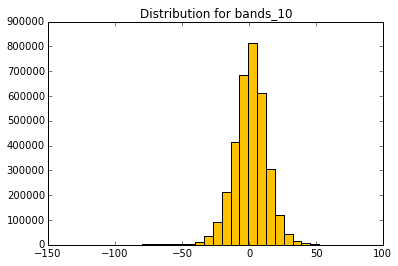

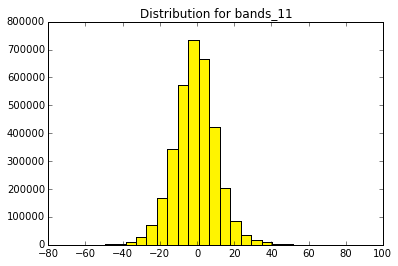

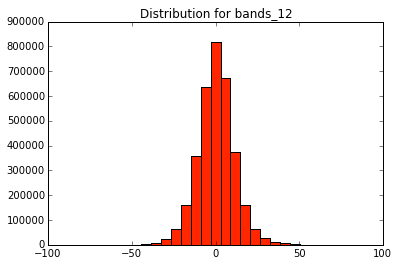

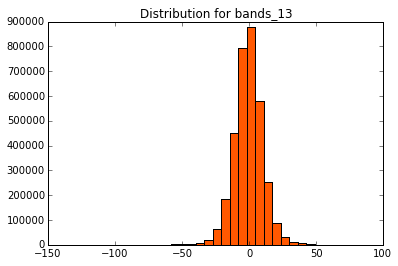

In [15]:
color = 0
for feature in featuresNames:
    histo = histograms[feature]
    width = histo[0][1] - histo[0][0]
    plt.bar(histo[0][:n], histo[1], width, log = False, color = plt.cm.autumn(color))
    color = (color + 50) % 256
    plt.title('Distribution for %s' % feature)
    plt.show()

### Ajout de features

In [ ]:
# building aggregations list
aggregate = ['bands_1', 'bands_2', 'bands_3', 'bands_4', 'bands_5', 'bands_6',
               'bands_7', 'bands_8', 'bands_9', 'bands_10', 'bands_11', 'bands_12', 'bands_13']
funs = [ F.avg, F.min, F.max ]
exprs = [f(F.col(c)) for f in funs for c in aggregate]
exprs

In [ ]:
mfcc_agg = mfcc.groupBy('idSound', 'class').agg(*exprs)
mfcc_agg.show(5)

In [ ]:
mfcc_agg.cache()

In [16]:
predictors = [column for column in mfcc.columns if 'bands_' in column ] 
predictors

['bands_1',
 'bands_2',
 'bands_3',
 'bands_4',
 'bands_5',
 'bands_6',
 'bands_7',
 'bands_8',
 'bands_9',
 'bands_10',
 'bands_11',
 'bands_12',
 'bands_13']

### Construction du pipeline de Machine Learning

Nous allons mettre en oeuvre une succession de transformations au jeu de données:

* indexation des labels (la mllib de Spark ne fonctionne que sur des nombres)
* regroupement des features: les colones bands_* vont être regroupées dans une colone _features_
* calcul du modèle

La doc SparkML est là: https://spark.apache.org/docs/1.6.2/ml-guide.html

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import Normalizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

In [ ]:
# comme d'habitude, on met une partie des données de côté
(trainingData, testData) = mfcc_agg.randomSplit([0.8, 0.2], seed = 1234)

labelIndexer = StringIndexer(inputCol='class', outputCol='classIndex').fit(mfcc_agg)

assembler = VectorAssembler(
    inputCols=predictors,
    outputCol='features')

normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)

rf = RandomForestClassifier(labelCol="classIndex", featuresCol="normFeatures", seed = 1234)

pipeline = Pipeline(stages=[labelIndexer, assembler, normalizer, rf])

model = pipeline.fit(trainingData)

In [ ]:
model.stages

Pendant que ça tourne, on peut vérifier l'avancement du job sur http://nn1.hdp3.bsa.broadsoftware.com:8088/cluster/apps

### Faire des prédictions

In [ ]:
rawPredictions = model.transform(testData)
rawPredictions.limit(5).toPandas()

In [ ]:
converter = IndexToString(inputCol="prediction", outputCol="classPrediction", labels = labelIndexer.labels)
predictions = converter.transform(rawPredictions)
predictions.select("idSound", "prediction", "classPrediction", "classIndex", "class", "features").show(5)

In [ ]:
predictions.limit(1).toPandas()

### Évaluation du modèle

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="classIndex", predictionCol="prediction", metricName="precision")

accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

In [ ]:
full_model = pipeline.fit(mfcc_agg)

In [ ]:
validation = sqlContext.read.parquet('/user/geraud/shazam/parquet/nc13-validation.parquet')
validation_agg = validation.groupBy('idSound', 'class').agg(*exprs)
rawPredictions = full_model.transform(validation_agg.select('idSound', *predictors))

predictions = converter.transform(rawPredictions).select('idSound', 'classPrediction').collect()

In [ ]:
predictions[1:10]

In [ ]:
import pandas as pd
submissionDf = pd.DataFrame(predictions, columns = ['idSound', 'class'])
submissionDf[:10]

In [ ]:
submissionDf.to_csv('my-submission.csv', index = False)

# Random Forest par mfcc

## Split par IdSound

In [18]:
mfcc.rdd.getNumPartitions()

6

In [19]:
idSounds = mfcc.select(mfcc.idSound, 'class').distinct()
idSounds.take(5)

# comme d'habitude, on met une partie des données de côté
(trainingIdSound, testIdSound) = idSounds.randomSplit([0.8, 0.2], seed = 1234)
print(trainingIdSound.count())
print(testIdSound.count())


852
190


In [22]:
trainingData = trainingIdSound.join(mfcc, mfcc.idSound == trainingIdSound.idSound, 'inner') \
    .drop(trainingIdSound.idSound) \
    .drop(trainingIdSound['class'])

trainingData.printSchema()
trainingData.persist()
trainingData.agg(F.approxCountDistinct(trainingData.idSound).alias('c')).show()

testingData = testIdSound.join(mfcc, mfcc.idSound == testIdSound.idSound) \
    .drop(testIdSound.idSound) \
    .drop(testIdSound['class'])

testingData.printSchema()
testingData.persist()
testingData.agg(F.approxCountDistinct(testingData.idSound).alias('c')).show()

root
 |-- idSound: long (nullable = true)
 |-- bands_1: double (nullable = true)
 |-- bands_2: double (nullable = true)
 |-- bands_3: double (nullable = true)
 |-- bands_4: double (nullable = true)
 |-- bands_5: double (nullable = true)
 |-- bands_6: double (nullable = true)
 |-- bands_7: double (nullable = true)
 |-- bands_8: double (nullable = true)
 |-- bands_9: double (nullable = true)
 |-- bands_10: double (nullable = true)
 |-- bands_11: double (nullable = true)
 |-- bands_12: double (nullable = true)
 |-- bands_13: double (nullable = true)
 |-- mfccSeq: long (nullable = true)
 |-- class: string (nullable = true)

+---+
|  c|
+---+
|863|
+---+

root
 |-- idSound: long (nullable = true)
 |-- bands_1: double (nullable = true)
 |-- bands_2: double (nullable = true)
 |-- bands_3: double (nullable = true)
 |-- bands_4: double (nullable = true)
 |-- bands_5: double (nullable = true)
 |-- bands_6: double (nullable = true)
 |-- bands_7: double (nullable = true)
 |-- bands_8: double (null

In [23]:
labelIndexer = StringIndexer(inputCol='class', outputCol='classIndex').fit(mfcc)

assembler = VectorAssembler(
    inputCols=predictors,
    outputCol='features')

normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)

rf = RandomForestClassifier(labelCol="classIndex", featuresCol="normFeatures", seed = 1234)

pipeline = Pipeline(stages=[labelIndexer, assembler, normalizer, rf])

model = pipeline.fit(trainingData)

In [24]:
# validation
rawPredictions = model.transform(testingData)
rawPredictions.limit(5).toPandas()
converter = IndexToString(inputCol="prediction", outputCol="classPrediction", labels = labelIndexer.labels)
predictions = converter.transform(rawPredictions)
predictions.select("idSound", "prediction", "classPrediction", "classIndex", "class", "features").show(5)

+-------+----------+---------------+----------+------------+--------------------+
|idSound|prediction|classPrediction|classIndex|       class|            features|
+-------+----------+---------------+----------+------------+--------------------+
|     32|       2.0|       dog_bark|       0.0|street_music|[-1136.52746582,2...|
|     32|       2.0|       dog_bark|       0.0|street_music|[-1094.26013184,4...|
|     32|       2.0|       dog_bark|       0.0|street_music|[-1068.75415039,7...|
|     32|       2.0|       dog_bark|       0.0|street_music|[-1046.7611084,96...|
|     32|       2.0|       dog_bark|       0.0|street_music|[-997.95880127,80...|
+-------+----------+---------------+----------+------------+--------------------+
only showing top 5 rows



In [27]:
groupedByIdSoundPredictions = predictions.groupBy(['idSound', 'classPrediction']) \
    .count() \
    .map(lambda row: (row[0], (row[1], row[2]))) \
    .reduceByKey(most_frequent) \
    .map(lambda row: (row[0], (row[1][0]))) \
    .collect()

In [59]:
pd.Categorical(groupedByIdSoundPredictions['class'])

TypeError: list indices must be integers, not str

In [57]:
import numpy as np
import pandas as pd

groupedByIdSoundPredictionsDf = pd.DataFrame(groupedByIdSoundPredictions, columns = ['idSound', 'class'])
groupedByIdSoundPredictionsDf['class'].astype('category')
groupedByIdSoundPredictionsDf[:10]
groupedByIdSoundPredictionsDf.dtypes

TypeError: data type "category" not understood

In [29]:

testIdSoundDf = testIdSound.toPandas()
testIdSoundDf[:10]

,idSound,class
0,147,dog_bark
1,747,dog_bark
2,347,engine_idling
3,239,dog_bark
4,1066,engine_idling
5,298,children_playing
6,812,engine_idling
7,1173,gun_shot
8,1104,engine_idling
9,650,engine_idling


In [30]:
testIdSoundDf.sort('idSound')

,idSound,class
51,3,drilling
67,4,street_music
19,5,car_horn
126,9,gun_shot
87,15,drilling
63,30,dog_bark
96,32,street_music
84,34,car_horn
68,35,children_playing
32,40,engine_idling


In [31]:
groupedByIdSoundPredictionsDf.sort('idSound')

,idSound,class
4,3,dog_bark
5,4,street_music
6,5,street_music
9,9,dog_bark
17,15,dog_bark
32,30,street_music
33,32,street_music
37,34,dog_bark
39,35,dog_bark
44,40,street_music


In [44]:
y_true = testIdSoundDf.sort('idSound')['class'].astype('category')
y_pred = testIdSoundDf.sort('idSound')['class'].astype('category')

TypeError: data type "category" not understood

In [38]:
y_true

51             drilling
67         street_music
19             car_horn
126            gun_shot
87             drilling
63             dog_bark
96         street_music
84             car_horn
68     children_playing
32        engine_idling
148               siren
61     children_playing
177               siren
134    children_playing
119          jackhammer
...
89             drilling
189            gun_shot
171            car_horn
153       engine_idling
133            dog_bark
136        street_music
125    air_conditionner
186            gun_shot
94             car_horn
31             car_horn
168            drilling
140            car_horn
132            dog_bark
13             dog_bark
62             gun_shot
Name: class, Length: 190, dtype: object

In [37]:
y_pred

51             drilling
67         street_music
19             car_horn
126            gun_shot
87             drilling
63             dog_bark
96         street_music
84             car_horn
68     children_playing
32        engine_idling
148               siren
61     children_playing
177               siren
134    children_playing
119          jackhammer
...
89             drilling
189            gun_shot
171            car_horn
153       engine_idling
133            dog_bark
136        street_music
125    air_conditionner
186            gun_shot
94             car_horn
31             car_horn
168            drilling
140            car_horn
132            dog_bark
13             dog_bark
62             gun_shot
Name: class, Length: 190, dtype: object

In [41]:
type(y_true)

pandas.core.series.Series

In [43]:
pd.crosstab(y_true, y_pred)

KeyError: 'Level class not found'

## Soumettre pour le challenge

In [26]:
def most_frequent(x, y):
    if(y[1] > x[1]):
        return y
    else:
        return x

Il va falloir regrouper les MFCC par idSound, donc un peu de debug ci-dessous sur le jeu de test:

In [ ]:
predictions[predictions.idSound == 4].groupBy(['idSound', 'classPrediction']) \
           .count() \
           .collect()

In [ ]:
predictions[predictions.idSound == 4].groupBy(['idSound', 'classPrediction']) \
    .count() \
    .map(lambda row: (row[0], (row[1], row[2]))) \
    .reduceByKey(most_frequent) \
    .collect()

    
# .agg(lambda x:x.value_counts().index[0]) 

In [ ]:
groupedByIdSoundPredictions = predictions.groupBy(['idSound', 'classPrediction']) \
    .count() \
    .map(lambda row: (row[0], (row[1], row[2]))) \
    .reduceByKey(most_frequent) \
    .collect()

In [ ]:
groupedByIdSoundPredictions[:10]

On prédit maintenant sur le jeu de validation:

In [ ]:
validation = sqlContext.read.parquet('/user/geraud/shazam/parquet/nc13-validation.parquet')

In [ ]:
validation.select(validation.columns[:15]).limit(5).toPandas()

In [ ]:
rawPredictions = model.transform(validation.select(validation.columns[:15]))

predictions = converter.transform(rawPredictions)
predictions.select("idSound", "prediction", "classPrediction", "features").show(5)

In [ ]:
groupedByIdSoundPredictions = predictions.groupBy(['idSound', 'classPrediction']) \
    .count() \
    .map(lambda row: (row[0], (row[1], row[2]))) \
    .reduceByKey(most_frequent) \
    .map(lambda row: (row[0], row[1][0])) \
    .collect()

In [ ]:
groupedByIdSoundPredictions[:10]

In [ ]:
import pandas as pd
submissionDf = pd.DataFrame(groupedByIdSoundPredictions, columns = ['idSound', 'class'])
    

In [ ]:
submissionDf[:10]

In [ ]:
submissionDf.to_csv('my-submission.csv', index = False)